In [16]:
import datetime, warnings, scipy 
import sklearn
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from lightgbm import plot_importance
import matplotlib.pyplot as plt

In [17]:
train = pickle.load( open( "../model_feed_output/train_model.pkl", "rb" ) )
pred = pickle.load( open( "../model_feed_output/pred_model.pkl", "rb" ) )
train = train.reset_index()
pred = pred.reset_index()

In [18]:
temp_year = pred['년'].copy()
temp_month = pred['월'].copy()
temp_day = pred['일'].copy()
temp_time = pred['계획'].copy()
temp_flt = pred['항공편'].copy()

In [19]:
missing_train = train.isnull().sum(axis=0).reset_index()
missing_train.columns = ['variable', 'missing values']
missing_train['filling factor (%)']=(train.shape[0]-missing_train['missing values'])/train.shape[0]*100
missing_train.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,index,0,100.0
1,CLA_4LYR_x,0,100.0
2,CLF_3LYR_x,0,100.0
3,BASE_3LYR_x,0,100.0
4,CLF_2LYR_x,0,100.0
5,BASE_2LYR_x,0,100.0
6,CLA_2LYR_x,0,100.0
7,CLF_1LYR_x,0,100.0
8,BASE_1LYR_x,0,100.0
9,CLA_1LYR_x,0,100.0


In [20]:
missing_pred = pred.isnull().sum(axis=0).reset_index()
missing_pred.columns = ['variable', 'missing values']
missing_pred['filling factor (%)']=(pred.shape[0]-missing_pred['missing values'])/pred.shape[0]*100
missing_pred.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,schedule_mean,2,99.987484
1,schedule_count,2,99.987484
2,schedule_max,2,99.987484
3,schedule_min,2,99.987484
4,order_mean,2,99.987484
5,ORDER,2,99.987484
6,schedule,1,99.993742
7,CLA_4LYR_y,0,100.000000
8,BASE_3LYR_x,0,100.000000
9,CLF_2LYR_x,0,100.000000


In [21]:
pred['schedule_mean'] = pred['schedule_mean'].fillna(0)
pred['schedule_count'] = pred['schedule_count'].fillna(0)
pred['schedule_max'] = pred['schedule_max'].fillna(0)
pred['schedule_min'] = pred['schedule_min'].fillna(0)
pred['order_mean'] = pred['order_mean'].fillna(0)
pred['ORDER'] = pred['ORDER'].fillna(0)
pred['schedule'] = pred['schedule'].fillna(0)

In [22]:
train['계획'] = train['계획'].apply(lambda x : 60 * float(x.split(':')[0]) + float(x.split(':')[1]))
pred['계획'] = pred['계획'].apply(lambda x : 60 * float(x.split(':')[0]) + float(x.split(':')[1]))
train['ORDER'] = train['ORDER'].apply(lambda x : int(x))
pred['ORDER'] = pred['ORDER'].apply(lambda x : int(x))

In [23]:
th = 3
idx = train[train['schedule_count'] < th]['schedule_min'].index
train['schedule_min'].loc[idx] = 0
train['schedule_max'].loc[idx] = 0
train['schedule_mean'].loc[idx] = 0
train['schedule_count'].loc[idx] = 0
train['schedule'].loc[idx] = 0

idx = pred[pred['schedule'] == -1].index
pred['schedule_min'].loc[idx] = 0
pred['schedule_max'].loc[idx] = 0
pred['schedule_mean'].loc[idx] = 0
pred['schedule_count'].loc[idx] = 0
pred['schedule'].loc[idx] = 0

In [24]:
train['schedule'] = train['schedule'].apply(lambda x : int(x))
pred['schedule'] = pred['schedule'].apply(lambda x : int(x))

In [25]:
for i in train.columns:
    ok = False
    for j in pred.columns:
        if i == j:
            ok = True
    if ok == False:
        print(i)

식별번호
실제
지연사유
결항
결항사유
부정기편


In [26]:
variables_to_remove = ['airlines_classified','비행노선','wind_shear','day_of_year','결항사유','요일','항공편','식별번호','지연사유','부정기편','년','월','일','실제','결항']
train.drop(variables_to_remove, axis = 1, inplace = True)

In [27]:
for i in pred.columns:
    ok = False
    for j in train.columns:
        if i == j:
            ok = True
    if ok == False:
        print(i)

년
월
일
요일
항공편
지연확률
airlines_classified
비행노선
wind_shear
day_of_year


In [28]:
variables_to_remove = ['airlines_classified','지연확률','비행노선','wind_shear','day_of_year','요일','항공편','년','월','일']
pred.drop(variables_to_remove, axis = 1, inplace = True)

In [29]:
for i in pred.columns:
    if type(pred[i][0]) != type(train[i][0]):
        print(i)

지연


In [30]:
len(pred)

15980

In [31]:
train.columns[101:]

Index(['CLA_4LYR_y', 'BASE_4LYR_y', 'ORDER', 'order_mean', 'schedule',
       'schedule_min', 'schedule_max', 'schedule_count', 'schedule_mean'],
      dtype='object')

In [32]:
train['schedule'] = train['schedule'].apply(lambda x : int(x))
variables_to_remove = ['지연']
x = train.drop(variables_to_remove, axis = 1)
pred = pred.drop(variables_to_remove, axis = 1)
y = train['지연']

In [33]:
cols = x.columns
col_name_list = []
name_list = ['절편']
start_point = 1
end_point = 0
i = 0
X = np.ones((len(x),1))
X_pred = np.ones((len(pred),1))

for col in cols:
    print(i, col)
    i = i + 1
    start_point = end_point + 1
    if(type(x.loc[0][col]) == str):
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(x[col])
        zipped = zip(integer_encoded, x[col])
        label = list(set(list(zipped)))
        for i in range(len(label)):
            name_list.append(label[i][1])
        end_point = start_point + len(set(integer_encoded)) - 1
        
        values = set(x[col].unique()) | set(pred[col].unique())
        values = list(values)
        x_temp = np.zeros((len(x), len(values)))
        x_pred_temp = np.zeros((len(pred), len(values)))
        temp_col = 0
        for value in values:
            idx1 = x[x[col] == value].index
            x_temp[idx1, temp_col] = 1
    
            idx2 = pred[pred[col] == value].index
            x_pred_temp[idx2, temp_col] = 1
            temp_col = temp_col + 1
        X = np.hstack((X,x_temp))
        X_pred = np.hstack((X_pred,x_pred_temp))
    else:
        X = np.hstack((X,np.array(x[col]).reshape(len(x),-1)))
        X_pred = np.hstack((X_pred,np.array(pred[col]).reshape(len(pred),-1)))
        col_name_list.append([start_point, start_point])
        end_point += 1
        name_list.append(col)
print(name_list)
Y = y.apply(lambda x : 1 if x == 'Y' else 0)

0 index
1 공항
12 출도착
1 상대공항
14 항공사
6 계획
7 departure_time
18 flo_del_start_x
19 계획시간별_평균지연시간
20 flo_del_start_y
21 flo_del_finish
22 flo_del_all
23 출발지연만_항공사별지연시간평균
24 도착지연만_항공사별지연시간평균
25 출발_항공사별지연시간평균
26 도착_항공사별지연시간평균
27 likelihood_x
28 count_x
29 likelihood_y
30 diff_y
31 count_y
32 likelihood_pred_x
33 count_pred_x
34 diff_pred_x
35 likelihood_pred_y
36 count_pred_y
37 diff_pred_y
38 총개수
39 개수(D)
40 지연율(D)
41 개수(A)
42 지연율(A)
43 출발편미지연_x_차이
44 출발편지연_x_차이
45 도착편미지연_y_차이
46 도착편지연_y_차이
47 출발편미지연_y_차이
48 출발편지연_y_차이
49 도착편미지연_x_차이
50 도착편지연_x_차이
51 mean_pressure_day
52 mean_temp_day
53 mean_speed_day
54 mean_cloud_day
55 mean_humid_day
56 mean_rain_day
57 visibillity
58 rvr
59 lowest_cloud
60 week_of_year
61 WD_x
62 WSPD_x
63 WS_GST_x
64 VIS_x
65 RVR1_x
66 RVR2_x
67 RVR3_x
68 RVR4_x
69 WC_x
70 TMP_x
71 TD_x
72 PS_x
73 PA_x
74 RN_x
75 HM_x
76 CA_TOT_x
77 CLA_1LYR_x
78 BASE_1LYR_x
79 CLF_1LYR_x
80 CLA_2LYR_x
81 BASE_2LYR_x
82 CLF_2LYR_x
83 BASE_3LYR_x
84 CLF_3LYR_x
85 CLA_4LYR_x
86 BASE_4LYR_x

In [34]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))
    return confusion

In [35]:
X_train_gbm , X_test_gbm, y_train_gbm, y_test_gbm = train_test_split(X, Y, test_size = 0.3, random_state  = 156)

lgbm_wrapper = LGBMClassifier(n_estimators = 1000, learning_rate = 0.05 ,lambda_l1 = 0.1)

evals = [(X_test_gbm, y_test_gbm)]
lgbm_wrapper.fit(X_train_gbm, y_train_gbm, early_stopping_rounds = 100, eval_metric = "logloss",
                 eval_set = evals, verbose = True)
preds_gbm = lgbm_wrapper.predict(X_test_gbm)
preds_gbm_ = lgbm_wrapper.predict_proba(X_test_gbm)

[1]	valid_0's binary_logloss: 0.362025	valid_0's binary_logloss: 0.362025
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.35434	valid_0's binary_logloss: 0.35434
[3]	valid_0's binary_logloss: 0.347807	valid_0's binary_logloss: 0.347807
[4]	valid_0's binary_logloss: 0.342133	valid_0's binary_logloss: 0.342133
[5]	valid_0's binary_logloss: 0.336942	valid_0's binary_logloss: 0.336942
[6]	valid_0's binary_logloss: 0.332339	valid_0's binary_logloss: 0.332339
[7]	valid_0's binary_logloss: 0.328229	valid_0's binary_logloss: 0.328229
[8]	valid_0's binary_logloss: 0.324551	valid_0's binary_logloss: 0.324551
[9]	valid_0's binary_logloss: 0.321165	valid_0's binary_logloss: 0.321165
[10]	valid_0's binary_logloss: 0.318111	valid_0's binary_logloss: 0.318111
[11]	valid_0's binary_logloss: 0.315287	valid_0's binary_logloss: 0.315287
[12]	valid_0's binary_logloss: 0.312646	valid_0's binary_logloss: 0.312646
[13]	valid_0's binary_logloss: 0.310262	valid_0'

[111]	valid_0's binary_logloss: 0.264121	valid_0's binary_logloss: 0.264121
[112]	valid_0's binary_logloss: 0.263995	valid_0's binary_logloss: 0.263995
[113]	valid_0's binary_logloss: 0.263861	valid_0's binary_logloss: 0.263861
[114]	valid_0's binary_logloss: 0.26374	valid_0's binary_logloss: 0.26374
[115]	valid_0's binary_logloss: 0.263653	valid_0's binary_logloss: 0.263653
[116]	valid_0's binary_logloss: 0.263535	valid_0's binary_logloss: 0.263535
[117]	valid_0's binary_logloss: 0.263399	valid_0's binary_logloss: 0.263399
[118]	valid_0's binary_logloss: 0.263296	valid_0's binary_logloss: 0.263296
[119]	valid_0's binary_logloss: 0.263228	valid_0's binary_logloss: 0.263228
[120]	valid_0's binary_logloss: 0.263109	valid_0's binary_logloss: 0.263109
[121]	valid_0's binary_logloss: 0.263013	valid_0's binary_logloss: 0.263013
[122]	valid_0's binary_logloss: 0.262914	valid_0's binary_logloss: 0.262914
[123]	valid_0's binary_logloss: 0.262835	valid_0's binary_logloss: 0.262835
[124]	valid_0'

[220]	valid_0's binary_logloss: 0.256228	valid_0's binary_logloss: 0.256228
[221]	valid_0's binary_logloss: 0.256202	valid_0's binary_logloss: 0.256202
[222]	valid_0's binary_logloss: 0.25615	valid_0's binary_logloss: 0.25615
[223]	valid_0's binary_logloss: 0.256103	valid_0's binary_logloss: 0.256103
[224]	valid_0's binary_logloss: 0.256058	valid_0's binary_logloss: 0.256058
[225]	valid_0's binary_logloss: 0.25604	valid_0's binary_logloss: 0.25604
[226]	valid_0's binary_logloss: 0.256	valid_0's binary_logloss: 0.256
[227]	valid_0's binary_logloss: 0.255944	valid_0's binary_logloss: 0.255944
[228]	valid_0's binary_logloss: 0.255914	valid_0's binary_logloss: 0.255914
[229]	valid_0's binary_logloss: 0.255878	valid_0's binary_logloss: 0.255878
[230]	valid_0's binary_logloss: 0.255853	valid_0's binary_logloss: 0.255853
[231]	valid_0's binary_logloss: 0.255814	valid_0's binary_logloss: 0.255814
[232]	valid_0's binary_logloss: 0.255768	valid_0's binary_logloss: 0.255768
[233]	valid_0's binary

[331]	valid_0's binary_logloss: 0.252967	valid_0's binary_logloss: 0.252967
[332]	valid_0's binary_logloss: 0.252957	valid_0's binary_logloss: 0.252957
[333]	valid_0's binary_logloss: 0.252946	valid_0's binary_logloss: 0.252946
[334]	valid_0's binary_logloss: 0.252928	valid_0's binary_logloss: 0.252928
[335]	valid_0's binary_logloss: 0.252917	valid_0's binary_logloss: 0.252917
[336]	valid_0's binary_logloss: 0.252889	valid_0's binary_logloss: 0.252889
[337]	valid_0's binary_logloss: 0.252867	valid_0's binary_logloss: 0.252867
[338]	valid_0's binary_logloss: 0.252862	valid_0's binary_logloss: 0.252862
[339]	valid_0's binary_logloss: 0.252841	valid_0's binary_logloss: 0.252841
[340]	valid_0's binary_logloss: 0.252812	valid_0's binary_logloss: 0.252812
[341]	valid_0's binary_logloss: 0.252812	valid_0's binary_logloss: 0.252812
[342]	valid_0's binary_logloss: 0.252794	valid_0's binary_logloss: 0.252794
[343]	valid_0's binary_logloss: 0.252764	valid_0's binary_logloss: 0.252764
[344]	valid_

[441]	valid_0's binary_logloss: 0.250786	valid_0's binary_logloss: 0.250786
[442]	valid_0's binary_logloss: 0.250779	valid_0's binary_logloss: 0.250779
[443]	valid_0's binary_logloss: 0.25078	valid_0's binary_logloss: 0.25078
[444]	valid_0's binary_logloss: 0.250736	valid_0's binary_logloss: 0.250736
[445]	valid_0's binary_logloss: 0.250725	valid_0's binary_logloss: 0.250725
[446]	valid_0's binary_logloss: 0.250719	valid_0's binary_logloss: 0.250719
[447]	valid_0's binary_logloss: 0.250676	valid_0's binary_logloss: 0.250676
[448]	valid_0's binary_logloss: 0.250643	valid_0's binary_logloss: 0.250643
[449]	valid_0's binary_logloss: 0.250612	valid_0's binary_logloss: 0.250612
[450]	valid_0's binary_logloss: 0.250579	valid_0's binary_logloss: 0.250579
[451]	valid_0's binary_logloss: 0.250568	valid_0's binary_logloss: 0.250568
[452]	valid_0's binary_logloss: 0.250542	valid_0's binary_logloss: 0.250542
[453]	valid_0's binary_logloss: 0.250528	valid_0's binary_logloss: 0.250528
[454]	valid_0'

[550]	valid_0's binary_logloss: 0.249109	valid_0's binary_logloss: 0.249109
[551]	valid_0's binary_logloss: 0.249107	valid_0's binary_logloss: 0.249107
[552]	valid_0's binary_logloss: 0.249095	valid_0's binary_logloss: 0.249095
[553]	valid_0's binary_logloss: 0.249093	valid_0's binary_logloss: 0.249093
[554]	valid_0's binary_logloss: 0.249087	valid_0's binary_logloss: 0.249087
[555]	valid_0's binary_logloss: 0.249085	valid_0's binary_logloss: 0.249085
[556]	valid_0's binary_logloss: 0.249075	valid_0's binary_logloss: 0.249075
[557]	valid_0's binary_logloss: 0.249065	valid_0's binary_logloss: 0.249065
[558]	valid_0's binary_logloss: 0.249061	valid_0's binary_logloss: 0.249061
[559]	valid_0's binary_logloss: 0.249052	valid_0's binary_logloss: 0.249052
[560]	valid_0's binary_logloss: 0.249042	valid_0's binary_logloss: 0.249042
[561]	valid_0's binary_logloss: 0.249034	valid_0's binary_logloss: 0.249034
[562]	valid_0's binary_logloss: 0.24903	valid_0's binary_logloss: 0.24903
[563]	valid_0'

[659]	valid_0's binary_logloss: 0.247867	valid_0's binary_logloss: 0.247867
[660]	valid_0's binary_logloss: 0.247853	valid_0's binary_logloss: 0.247853
[661]	valid_0's binary_logloss: 0.247831	valid_0's binary_logloss: 0.247831
[662]	valid_0's binary_logloss: 0.247816	valid_0's binary_logloss: 0.247816
[663]	valid_0's binary_logloss: 0.247815	valid_0's binary_logloss: 0.247815
[664]	valid_0's binary_logloss: 0.247808	valid_0's binary_logloss: 0.247808
[665]	valid_0's binary_logloss: 0.247803	valid_0's binary_logloss: 0.247803
[666]	valid_0's binary_logloss: 0.247803	valid_0's binary_logloss: 0.247803
[667]	valid_0's binary_logloss: 0.247786	valid_0's binary_logloss: 0.247786
[668]	valid_0's binary_logloss: 0.247768	valid_0's binary_logloss: 0.247768
[669]	valid_0's binary_logloss: 0.247767	valid_0's binary_logloss: 0.247767
[670]	valid_0's binary_logloss: 0.247741	valid_0's binary_logloss: 0.247741
[671]	valid_0's binary_logloss: 0.24774	valid_0's binary_logloss: 0.24774
[672]	valid_0'

[768]	valid_0's binary_logloss: 0.246697	valid_0's binary_logloss: 0.246697
[769]	valid_0's binary_logloss: 0.246693	valid_0's binary_logloss: 0.246693
[770]	valid_0's binary_logloss: 0.246679	valid_0's binary_logloss: 0.246679
[771]	valid_0's binary_logloss: 0.246645	valid_0's binary_logloss: 0.246645
[772]	valid_0's binary_logloss: 0.246643	valid_0's binary_logloss: 0.246643
[773]	valid_0's binary_logloss: 0.246643	valid_0's binary_logloss: 0.246643
[774]	valid_0's binary_logloss: 0.246639	valid_0's binary_logloss: 0.246639
[775]	valid_0's binary_logloss: 0.246629	valid_0's binary_logloss: 0.246629
[776]	valid_0's binary_logloss: 0.246625	valid_0's binary_logloss: 0.246625
[777]	valid_0's binary_logloss: 0.246621	valid_0's binary_logloss: 0.246621
[778]	valid_0's binary_logloss: 0.246612	valid_0's binary_logloss: 0.246612
[779]	valid_0's binary_logloss: 0.246599	valid_0's binary_logloss: 0.246599
[780]	valid_0's binary_logloss: 0.246574	valid_0's binary_logloss: 0.246574
[781]	valid_

[879]	valid_0's binary_logloss: 0.245804	valid_0's binary_logloss: 0.245804
[880]	valid_0's binary_logloss: 0.245805	valid_0's binary_logloss: 0.245805
[881]	valid_0's binary_logloss: 0.2458	valid_0's binary_logloss: 0.2458
[882]	valid_0's binary_logloss: 0.245798	valid_0's binary_logloss: 0.245798
[883]	valid_0's binary_logloss: 0.245795	valid_0's binary_logloss: 0.245795
[884]	valid_0's binary_logloss: 0.245792	valid_0's binary_logloss: 0.245792
[885]	valid_0's binary_logloss: 0.24579	valid_0's binary_logloss: 0.24579
[886]	valid_0's binary_logloss: 0.245787	valid_0's binary_logloss: 0.245787
[887]	valid_0's binary_logloss: 0.245774	valid_0's binary_logloss: 0.245774
[888]	valid_0's binary_logloss: 0.245765	valid_0's binary_logloss: 0.245765
[889]	valid_0's binary_logloss: 0.245739	valid_0's binary_logloss: 0.245739
[890]	valid_0's binary_logloss: 0.24574	valid_0's binary_logloss: 0.24574
[891]	valid_0's binary_logloss: 0.245738	valid_0's binary_logloss: 0.245738
[892]	valid_0's bina

In [36]:
con_mat_gbm = get_clf_eval(y_test_gbm, (preds_gbm_ < 0.5)[:,0])
fallout_gbm = con_mat_gbm[0,0] / (con_mat_gbm[0,0] + con_mat_gbm[0,1])
recall_gbm =  con_mat_gbm[1,0] / (con_mat_gbm[1,0] + con_mat_gbm[1,1])
# 재연율 0.7068입니다. 아래는 잘못 출력되었습니다.

오차 행렬
[[251909   4065]
 [ 25180  10446]]
정확도: 0.8997, 정밀도: 0.7199, 재현율: 0.2932


c:\users\alsgh\anaconda3\envs\bigcon\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\alsgh\anaconda3\envs\bigcon\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':


오차 행렬
[[255974      0]
 [ 35626      0]]
정확도: 0.8778, 정밀도: 0.0000, 재현율: 0.0000
오차 행렬
[[255974      0]
 [ 34995    631]]
정확도: 0.8800, 정밀도: 1.0000, 재현율: 0.0177
오차 행렬
[[255973      1]
 [ 34971    655]]
정확도: 0.8801, 정밀도: 0.9985, 재현율: 0.0184
오차 행렬
[[255972      2]
 [ 34920    706]]
정확도: 0.8802, 정밀도: 0.9972, 재현율: 0.0198
오차 행렬
[[255972      2]
 [ 34879    747]]
정확도: 0.8804, 정밀도: 0.9973, 재현율: 0.0210
오차 행렬
[[255969      5]
 [ 34810    816]]
정확도: 0.8806, 정밀도: 0.9939, 재현율: 0.0229
오차 행렬
[[255966      8]
 [ 34745    881]]
정확도: 0.8808, 정밀도: 0.9910, 재현율: 0.0247
오차 행렬
[[255965      9]
 [ 34645    981]]
정확도: 0.8812, 정밀도: 0.9909, 재현율: 0.0275
오차 행렬
[[255958     16]
 [ 34541   1085]]
정확도: 0.8815, 정밀도: 0.9855, 재현율: 0.0305
오차 행렬
[[255953     21]
 [ 34443   1183]]
정확도: 0.8818, 정밀도: 0.9826, 재현율: 0.0332
오차 행렬
[[255945     29]
 [ 34339   1287]]
정확도: 0.8821, 정밀도: 0.9780, 재현율: 0.0361
오차 행렬
[[255936     38]
 [ 34215   1411]]
정확도: 0.8825, 정밀도: 0.9738, 재현율: 0.0396
오차 행렬
[[255931     43]
 [ 34092   1534]]
정확도: 0.8829

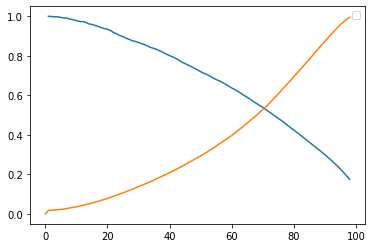

In [37]:
precision = []
recall = []
for th in range(0,99):
    if th >= 99:
        break
    th = th / 100
    pred_y = (preds_gbm_[:,0] < th)
    con_mat_gbm_ = get_clf_eval(y_test_gbm, pred_y)
    precision_gbm_ = con_mat_gbm_[1,1] / (con_mat_gbm_[0,1] + con_mat_gbm_[1,1])
    recall_gbm_ =  con_mat_gbm_[1,1] / (con_mat_gbm_[1,0] + con_mat_gbm_[1,1])
    precision.append(precision_gbm_)
    recall.append(recall_gbm_)

plt.legend([['precision', 'recall']])
plt.plot(precision)
plt.plot(recall)
plt.savefig('th.jpg', dpi=300)
plt.show()

In [38]:
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test_gbm, lgbm_wrapper.predict_proba(X_test_gbm)[:, 1])
fpr_gbm, tpr_gbm, thresholds_gbm

(array([0.        , 0.        , 0.        , ..., 0.75680343, 0.75680343,
        1.        ]),
 array([0.00000000e+00, 2.80693875e-05, 1.77959917e-02, ...,
        9.99971931e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.99993239e+00, 9.99932391e-01, 9.89103446e-01, ...,
        4.61380031e-03, 4.61344850e-03, 2.24058793e-05]))

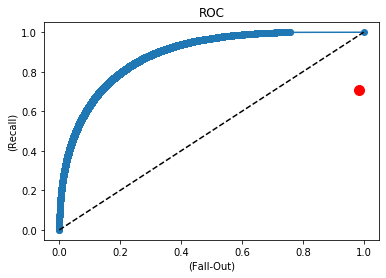

In [39]:
plt.plot(fpr_gbm, tpr_gbm, 'o-', label="L")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout_gbm], [recall_gbm], 'ro', ms=10)
plt.xlabel('(Fall-Out)')
plt.ylabel('(Recall)')
plt.title('ROC')
plt.show()

In [40]:
auc(fpr_gbm, tpr_gbm)

0.8856490699359649

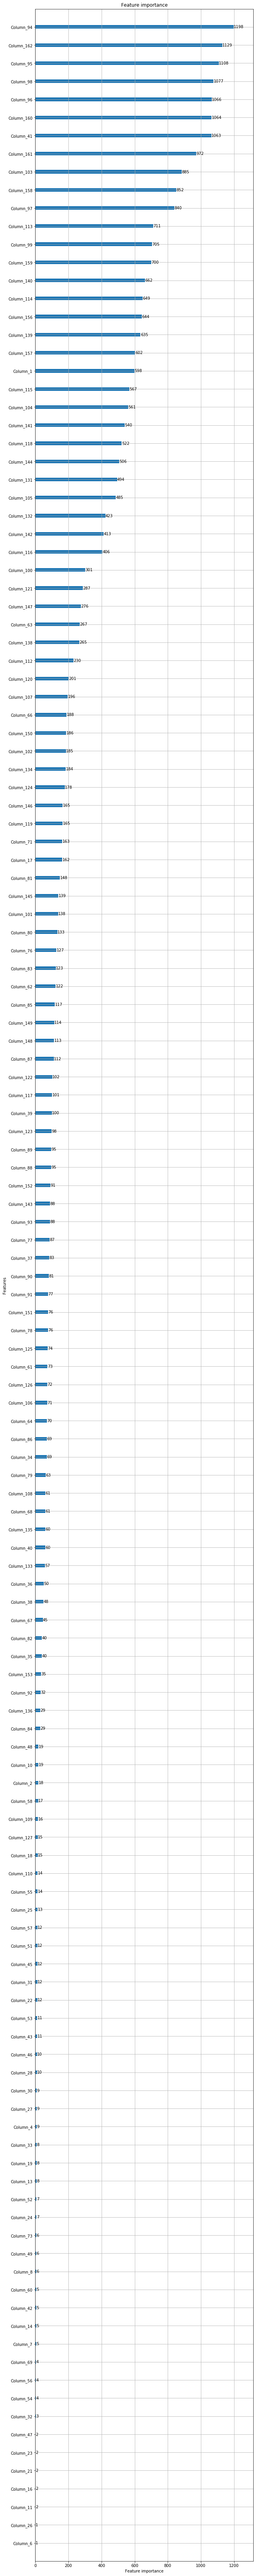

In [41]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,120))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('fig17.jpg', dpi=300)
plt.show()

In [42]:
dict_name = {}
for i in range(len(name_list)):
    dict_name[i] = name_list[i]
dict_name

{0: '절편',
 1: 'index',
 2: '인천',
 3: '무안',
 4: '김포',
 5: '사천',
 6: '청주',
 7: '양양',
 8: '울산',
 9: '광주',
 10: '대구',
 11: '제주',
 12: '여수',
 13: '포항',
 14: '김해',
 15: '도착',
 16: '출발',
 17: '김해',
 18: '제주',
 19: '군산',
 20: '포항',
 21: '광주',
 22: '울산',
 23: '청주',
 24: '양양',
 25: '인천',
 26: '여수',
 27: '김포',
 28: '원주',
 29: '무안',
 30: '사천',
 31: '대구',
 32: '대한항공',
 33: '제주항공',
 34: '에어부산',
 35: '진에어',
 36: '이스타',
 37: '아시아나',
 38: '티웨이',
 39: '계획',
 40: '20',
 41: '21',
 42: '17',
 43: '16',
 44: '11',
 45: '10',
 46: '12',
 47: '09',
 48: '06',
 49: '14',
 50: '13',
 51: '19',
 52: '08',
 53: '00',
 54: '05',
 55: '15',
 56: '22',
 57: '07',
 58: '18',
 59: 'flo_del_start_x',
 60: '계획시간별_평균지연시간',
 61: 'flo_del_start_y',
 62: 'flo_del_finish',
 63: 'flo_del_all',
 64: '출발지연만_항공사별지연시간평균',
 65: '도착지연만_항공사별지연시간평균',
 66: '출발_항공사별지연시간평균',
 67: '도착_항공사별지연시간평균',
 68: 'likelihood_x',
 69: 'count_x',
 70: 'likelihood_y',
 71: 'diff_y',
 72: 'count_y',
 73: 'likelihood_pred_x',
 74: 'count_pred_x',
 75: 

In [43]:
preds_pred_gbm = lgbm_wrapper.predict_proba(X_pred)

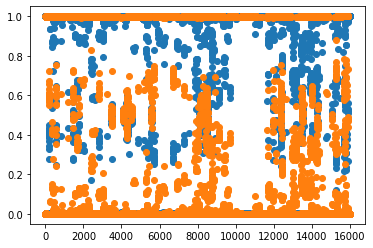

In [44]:
plt.plot(preds_pred_gbm,'o')

In [45]:
pred['지연확률'] = preds_pred_gbm[:,1]

In [46]:
pred['지연'] = 0
pred['지연'].loc[preds_pred_gbm[:,1] > 0.5] = 1

c:\users\alsgh\anaconda3\envs\bigcon\lib\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [47]:
pred.head()

,index,공항,출도착,상대공항,항공사,계획,departure_time,flo_del_start_x,계획시간별_평균지연시간,flo_del_start_y,...,BASE_4LYR_y,ORDER,order_mean,schedule_min,schedule_max,schedule_count,schedule_mean,schedule,지연확률,지연
0,0,김포,도착,제주,티웨이,545.0,09,12.135248,21.176038,19.65812,...,0.0,1,1.350937,-5.0,-5.0,1.0,-5.0,20231,0.000312,0
1,1,김포,도착,제주,티웨이,595.0,09,12.135248,21.176038,19.65812,...,0.0,3,5.166557,-2.0,-2.0,1.0,-2.0,19040,0.000684,0
2,2,김포,도착,제주,티웨이,545.0,09,12.135248,21.176038,19.65812,...,0.0,3,5.166557,-4.0,-4.0,1.0,-4.0,20264,0.000532,0
3,3,김포,도착,제주,티웨이,595.0,09,12.135248,21.176038,19.65812,...,0.0,4,20.777100,6.0,6.0,1.0,6.0,19991,0.000520,0
4,4,김포,도착,제주,티웨이,545.0,09,12.135248,21.176038,19.65812,...,0.0,1,1.350937,-5.0,-5.0,1.0,-5.0,20231,0.000313,0


In [48]:
sum(pred['지연확률'])

3542.3795115334565

In [49]:
sum(pred['지연']) == sum(preds_pred_gbm[:,1] > 0.5)

True

In [50]:
pred.to_csv("final.csv", encoding='cp949')

In [51]:
original = pd.read_csv("../input/AFSNT_DLY.csv", engine = "python", encoding = "CP949")
variables_to_remove = ["DLY","DLY_RATE"]
original.drop(variables_to_remove, axis = 1, inplace = True)

In [52]:
pred['SDT_YY'] = temp_year
pred['SDT_MM'] = temp_month
pred['SDT_DD'] = temp_day
pred['STT'] = temp_time
pred['FLT'] = temp_flt
pred = pred[['SDT_YY','SDT_MM','SDT_DD','STT','FLT','지연','지연확률']]

In [53]:
pred = pred.rename(columns={"지연" : "DLY",
                           "지연확률" : "DLY_RATE",
                  })

In [54]:
original = pd.merge(original,pred, on = ['SDT_YY','SDT_MM','SDT_DD','FLT','STT'], how = 'outer')

In [55]:
original['DLY'] = original['DLY'].fillna(1)
original['DLY_RATE'] = original['DLY_RATE'].fillna(0.5)

In [56]:
original.to_csv("../답안파일/final.csv", encoding='cp949')